In [1]:
import numpy as np

Note: Linear Discriminant Analysis (LDA) is a method for dimension reduction. It considers the feature distribution of different classes and finds the projection vectors that maximize the difference between data samples in different classes.

## Load Data

In [2]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

In [3]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [4]:
# Convert the class labels into numbers
from sklearn.preprocessing import LabelEncoder

X = df[['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm']].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

In [5]:
%matplotlib inline

## LDA in 5 Steps

In [6]:
## Step 1: Computing the d-dimenstional mean vectors
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



In [7]:
## Step 2: Computing the Scatter Matrices
# 2.1 within-class scatter matrix 
S_W = np.zeros((4,4))

for cl, mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
        
    S_W += class_sc_mat
print('within-class scatter matrix:\n', S_W)
    

within-class scatter matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [8]:
# 2.2 Between-class scatter matrix SB
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i, mean_vec in enumerate(mean_vectors):
    
    n = X[y==i+1].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1)
    
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


In [9]:
## Step 3: Solving the generalized eigenvalue problem for the matrix inv(SW)SB
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))


for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.8844]
 [ 0.2854]
 [ 0.258 ]
 [ 0.2643]]
Eigenvalue 3: 3.42e-15

Eigenvector 4: 
[[-0.2234]
 [-0.2523]
 [-0.326 ]
 [ 0.8833]]
Eigenvalue 4: 1.15e-14


Both eigenvectors and eigenvalues are providing us with information about the distortion of a linear transformation.

THe eigenvectors are basically the direction of the distortion.

The eigenvalues are the scaling factor for the eigenvectors that describing the magnitude of the distortion. 

In [10]:
## Quick check the eigenvector-eigenvalue calculation
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


In [11]:
## Step 4: Selecting linear discriminants for the new feature subspace
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.27195779972981
0.27756686384003953
1.1483362279322388e-14
3.422458920849769e-15


In [13]:
## Step 4.2: Choose k eigenvectors with the largest eigenvalues
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


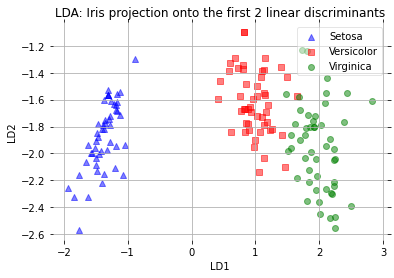

In [14]:
## Step 5: Transforming the samples onto the new subspace
X_lda = X.dot(W)

from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()


## A comparison of PCA and LDA
PCA finds the axes with maximum variance for the whole dataset
LDA tries to find the axes for best class seperability

In practice, often a PCA is done followed by a LDA for dimensionality reduction.

In [16]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()

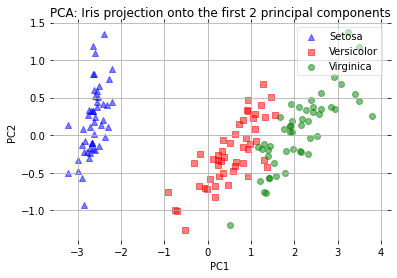

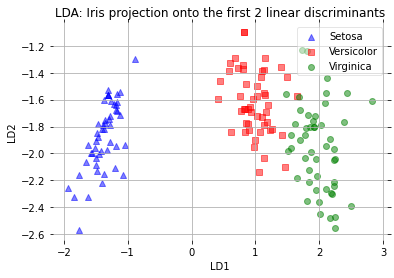

In [17]:
plot_pca()
plot_step_lda()

The PCA accounts for the most variance in the whole dataset, 
the LDA gives us the axes that account for the most variance between 
the individual classes.

In [18]:
##https://sebastianraschka.com/Articles/2014_python_lda.html#principal-component-analysis-vs-linear-discriminant-analysis